In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from gatys import  image_loader, imshow, run_style_transfer
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights


import copy

/Users/Hippolyte/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tests on Gatys et al Neural-Style algorithm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

content_img = image_loader(loader,"/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/val2017/000000002431.jpg",device)
content_img = image_loader(loader,"/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/val2017/000000581357.jpg",device)

style_img = image_loader(loader,"/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/wikiart_small/ernst-ludwig-kirchner_two-women-at-the-street.jpg",device)

print(content_img.size(),style_img.size())

if content_img.size()[2]*content_img.size()[3] > style_img.size()[2]*style_img.size()[3]:
    print("resizing")
    content_img = transforms.functional.crop(content_img,0,0,style_img.size()[2],style_img.size()[3])
    print(content_img.size(),style_img.size())
elif content_img.size()[2]*content_img.size()[3] < style_img.size()[2]*style_img.size()[3]:
    print("resizing")
    style_img = transforms.functional.crop(style_img,0,0,content_img.size()[2],content_img.size()[3])
    print(content_img.size(),style_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 173, 128])
resizing
torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


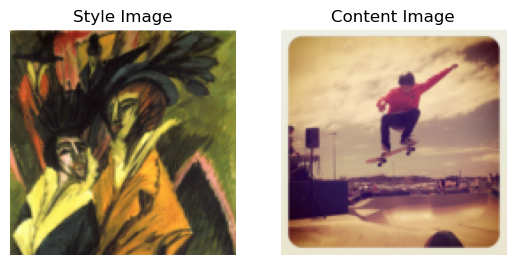

In [7]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

fig, ax = plt.subplots(1,2)
imshow(ax[0],style_img,unloader, title='Style Image')
imshow(ax[1], content_img,unloader, title='Content Image')

In [ ]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
fig, ax = plt.subplots(1,1)
imshow(ax, input_img, title='Input Image')

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=1000)


Building the style transfer model..


/Users/Hippolyte/anaconda3/envs/nlp/lib/python3.11/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 344.434601 Content Loss: 25.023453

run [100]:
Style Loss : 124.583542 Content Loss: 29.173197

run [150]:
Style Loss : 65.040802 Content Loss: 30.610903

run [200]:
Style Loss : 40.220463 Content Loss: 30.416546

run [250]:
Style Loss : 27.649134 Content Loss: 29.756367

run [300]:
Style Loss : 19.975193 Content Loss: 28.885437

run [350]:
Style Loss : 15.299991 Content Loss: 28.121861

run [400]:
Style Loss : 12.207402 Content Loss: 27.518160

run [450]:
Style Loss : 10.176829 Content Loss: 26.999723

run [500]:
Style Loss : 8.700378 Content Loss: 26.593115

run [550]:
Style Loss : 7.737153 Content Loss: 26.220694

run [600]:
Style Loss : 7.089676 Content Loss: 25.904562

run [650]:
Style Loss : 6.591931 Content Loss: 25.638361

run [700]:
Style Loss : 6.269501 Content Loss: 25.400997

run [750]:
Style Loss : 5.968795 Content Loss: 25.238491

run [800]:
Style Loss : 5.744140 Content Loss: 25.082327

run [850]:
Style Loss : 5.587622 Content Loss: 24

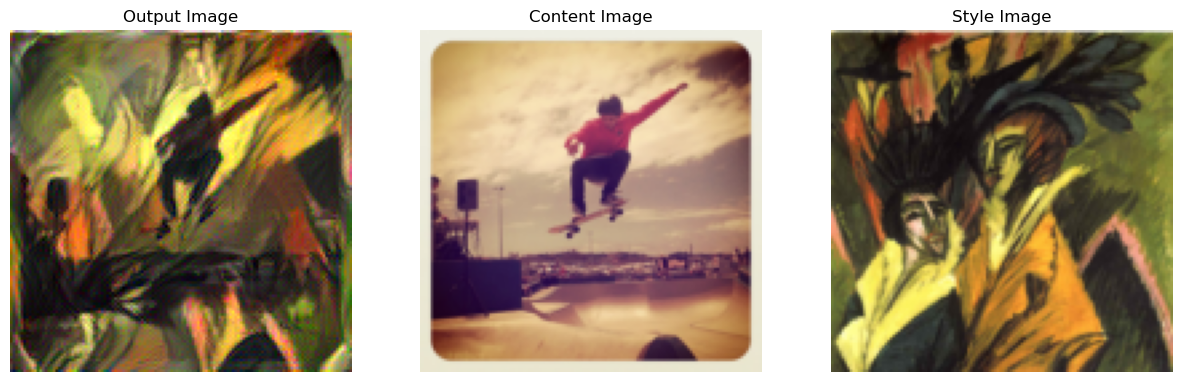

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
imshow(ax[0], output, unloader, title='Output Image')
imshow(ax[1], content_img,unloader, title='Content Image')
imshow(ax[2], style_img,unloader, title='Style Image')
plt.show()